# Dataset & Dataloader

In [85]:
!hostname

gl1012.arc-ts.umich.edu


In [86]:
# import os
# from dotenv import load_dotenv

# load_dotenv()
# data_dir_root = os.getenv("DATA_DIR")
data_dir_root = "/scratch/jjparkcv_root/jjparkcv98/minsukc/"
print(data_dir_root)

/scratch/jjparkcv_root/jjparkcv98/minsukc/


### Dataset

In [87]:
import os
import torchio as tio

In [88]:
def create_synthrad_dataset(root_dir):
    """
    Create a TorchIO SubjectsDataset for SynthRAD2025 Task 1 (MRI→CT).

    Args:
        root_dir (str): Path to the Task1 directory, e.g. './SynthRAD2025/Task1'
    Returns:
        tio.SubjectsDataset: TorchIO dataset containing (mr, ct, mask)
    """

    subjects = []

    # Each subfolder (AB, HN, TH)
    for anatomy in sorted(os.listdir(root_dir)):
        anatomy_path = os.path.join(root_dir, anatomy)
        if not os.path.isdir(anatomy_path):
            continue

        # Each patient folder, e.g. 1HNA001
        for patient in sorted(os.listdir(anatomy_path)):
            patient_path = os.path.join(anatomy_path, patient)
            if not os.path.isdir(patient_path):
                continue

            # mr_path = os.path.join(patient_path, "mr.nii")
            # ct_path = os.path.join(patient_path, "ct.nii")
            # mask_path = os.path.join(patient_path, "mask.nii")
            mr_path = os.path.join(patient_path, "mr.nii.gz")
            ct_path = os.path.join(patient_path, "ct.nii.gz")
            mask_path = os.path.join(patient_path, "mask.nii.gz")
            # mr_path = os.path.join(patient_path, "mr.mha")
            # ct_path = os.path.join(patient_path, "ct.mha")
            # mask_path = os.path.join(patient_path, "mask.mha")

            # Verify existence
            if not (os.path.exists(mr_path) and os.path.exists(ct_path)):
                continue

            subject = tio.Subject(
                id=patient,
                anatomy=anatomy,
                mr=tio.ScalarImage(mr_path),
                ct=tio.ScalarImage(ct_path),
                mask=tio.LabelMap(mask_path),
            )

            subjects.append(subject)

    # Define preprocessing/augmentation transforms
    # transform = tio.Compose([
    #     tio.Resample((1.0, 1.0, 1.0)),       # resample to 1mm isotropic voxels
    #     tio.ZNormalization(),                 # normalize MRI intensity
    #     tio.RandomFlip(axes=(0, 1, 2)),       # random flipping
    # ])
    # dataset = tio.SubjectsDataset(subjects, transform=transform)

    dataset = tio.SubjectsDataset(subjects)
    return dataset


### Dataloader

In [89]:
from torch.utils.data import DataLoader

# data_dir = os.path.join(data_dir_root, "SynthRAD2023/Task1")
data_dir = os.path.join(data_dir_root, "SynthRAD2025/Task1")
print(data_dir)
print("*** Use .nii for SynthRAD2023!")
dataset = create_synthrad_dataset(data_dir)
print(f"Total cases: {len(dataset)}")

loader = DataLoader(dataset, batch_size=1, shuffle=True)
# 890 * 0.65 = 578
# 578 - center D samples

/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1
*** Use .nii for SynthRAD2023!
Total cases: 513


In [90]:
from collections import Counter

counts = Counter([subj["anatomy"] for subj in dataset])
print(counts)

Counter({'TH': 182, 'AB': 175, 'HN': 156})


In [91]:
batch = next(iter(loader))
print("MRI shape:", batch["mr"][tio.DATA].shape)
print("CT shape:", batch["ct"][tio.DATA].shape)
print("Mask shape:", batch["mask"][tio.DATA].shape)

MRI shape: torch.Size([1, 1, 546, 407, 104])
CT shape: torch.Size([1, 1, 546, 407, 104])
Mask shape: torch.Size([1, 1, 546, 407, 104])


/home/minsukc/micromamba/envs/mri2ct/lib/python3.10/site-packages/torchio/data/image.py:253: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


In [92]:
batch = next(iter(loader))
print("MRI shape:", batch["mr"]["data"][0].shape)
print("CT shape:", batch["ct"]["data"][0].shape)
print("Mask shape:", batch["mask"]["data"][0].shape)

MRI shape: torch.Size([1, 547, 520, 152])
CT shape: torch.Size([1, 547, 520, 152])
Mask shape: torch.Size([1, 547, 520, 152])


In [93]:
# Access a single Subject (not batched)
subject = dataset[0]

print("MRI spacing:", subject["mr"].spacing)
print("CT spacing:", subject["ct"].spacing)
print("MRI orientation:", subject["mr"].orientation)
print("CT orientation:", subject["ct"].orientation)

MRI spacing: (np.float64(1.0), np.float64(1.0), np.float64(3.0))
CT spacing: (np.float64(1.0), np.float64(1.0), np.float64(3.0))
MRI orientation: ('L', 'P', 'S')
CT orientation: ('L', 'P', 'S')


#### Train/Val/Test split dataloader

In [94]:
from torch.utils.data import random_split, DataLoader
import torch

# --- Split ratios ---
train_ratio, val_ratio, test_ratio = 0.65, 0.10, 0.25
n_total = len(dataset)
n_train = int(train_ratio * n_total)
n_val = int(val_ratio * n_total)
n_test = n_total - n_train - n_val

# --- Random split ---
train_ds, val_ds, test_ds = random_split(
    dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

Train: 333 | Val: 51 | Test: 129


In [95]:
print("Example IDs:")
print("Train:", train_ds[0]["id"])
print("Val:", val_ds[0]["id"])
print("Test:", test_ds[0]["id"])

Example IDs:
Train: 1THA049
Val: 1THA235
Test: 1HNA089


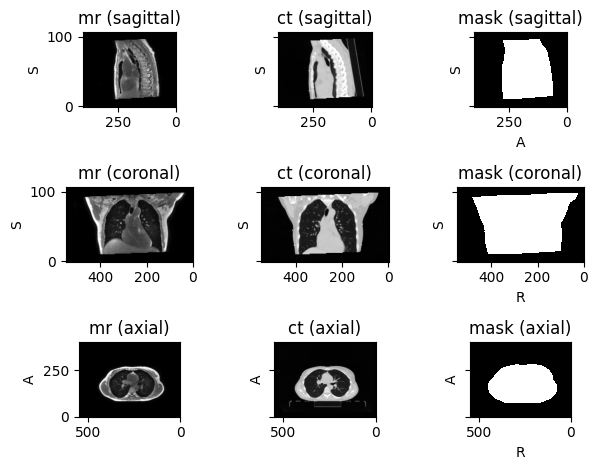

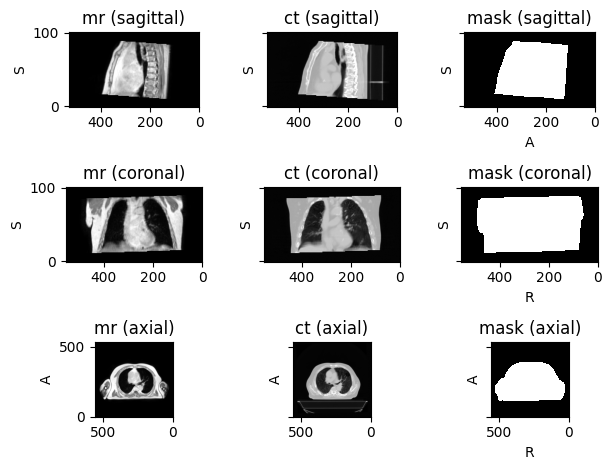

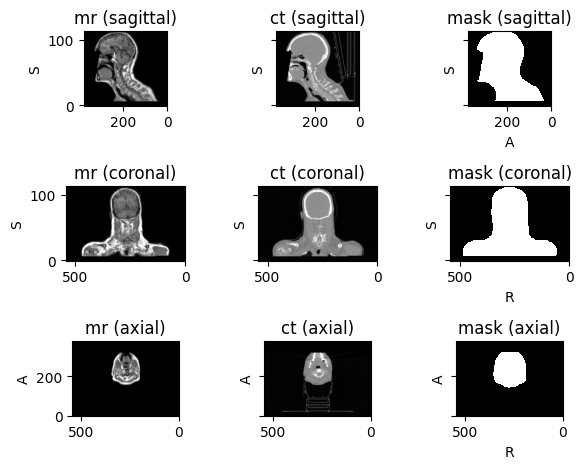

In [96]:
train_ds[0].plot()
val_ds[0].plot()
test_ds[0].plot()

### Visualization

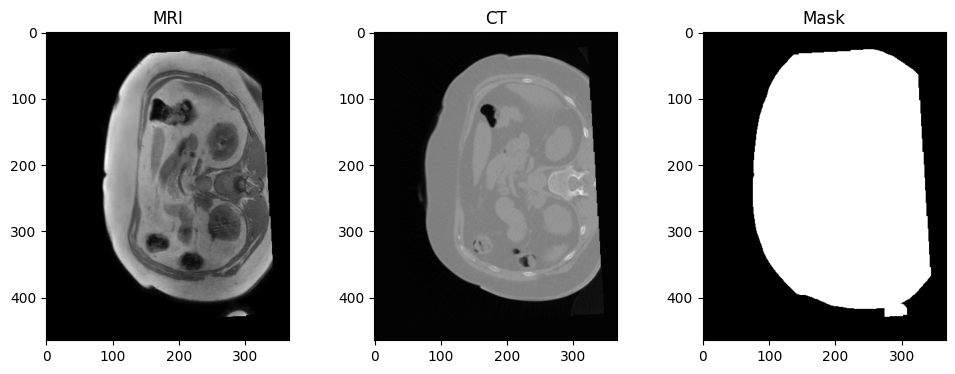

In [97]:
import matplotlib.pyplot as plt
import torchio as tio

subject = dataset[0]
mr = subject["mr"].data[0]
ct = subject["ct"].data[0]
mask = subject["mask"].data[0]

# Pick middle slice along z-axis
z = mr.shape[-1] // 2

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mr[..., z], cmap="gray")
plt.title("MRI")

plt.subplot(1, 3, 2)
plt.imshow(ct[..., z], cmap="gray")
plt.title("CT")

plt.subplot(1, 3, 3)
plt.imshow(mask[..., z], cmap="gray")
plt.title("Mask")

plt.show()

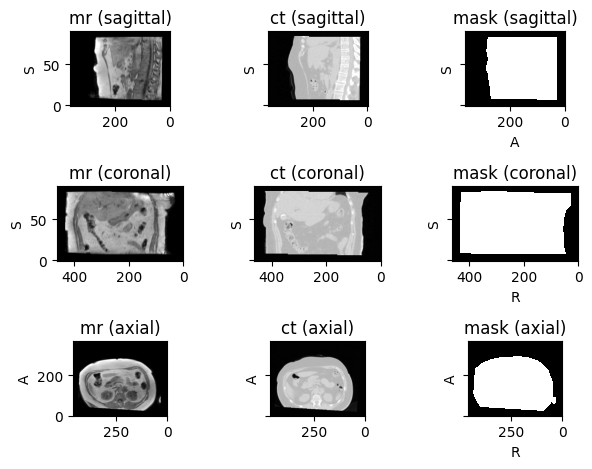

In [98]:
# Central sagittal, coronal, axial slices
subject.plot()

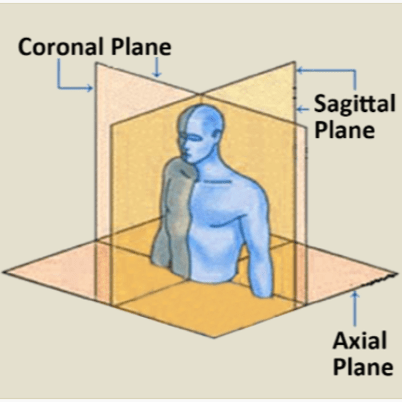

# Comparing 2023 vs 2025

In [118]:
import os
import nibabel as nib
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm


def get_physical_extent(nii_path):
    img = nib.load(nii_path)
    shape = np.array(img.shape[:3])
    spacing = np.array(img.header.get_zooms())
    extent = shape * spacing  # mm units
    return extent


def get_hist_signature(nii_path, bins=64, pmin=1, pmax=99):
    img = nib.load(nii_path)
    data = img.get_fdata()
    lo, hi = np.percentile(data, [pmin, pmax])
    data = np.clip(data, lo, hi)
    hist, _ = np.histogram(data, bins=bins, range=(lo, hi))
    hist = hist / np.sum(hist)  # normalize to sum=1
    return hist


def get_metadata(path):
    """Extract (shape, spacing, mean intensity, path) from a medical image."""
    ext = os.path.splitext(path)[1].lower()
    try:
        if ext == ".nii" or ext == ".gz":
            img = nib.load(path)
            return {
                "shape": img.shape,
                "spacing": img.header.get_zooms(),
                "mean_intensity": np.mean(img.get_fdata()),
                "path": path,
                "physical_extent": get_physical_extent(path),
                # "hist": get_hist_signature(path),
            }
        # elif ext == ".mha":
        #     img = sitk.ReadImage(path)
        #     arr = sitk.GetArrayFromImage(img)
        #     return {
        #         "shape": arr.shape,
        #         "spacing": img.GetSpacing(),
        #         "mean_intensity": np.mean(arr),
        #         "path": path,
        #     }
    except Exception as e:
        print(f"[!] Failed to read {path}: {e}")
    return None


def collect_info(root):
    """Walk through a dataset directory and collect image metadata."""
    all_files = []
    for dirpath, _, filenames in os.walk(root):
        for f in filenames:
            # if f.endswith((".nii", ".mha")) and ("mask" not in f):
            if f.endswith((".nii", ".nii.gz")) and ("mask" not in f):
                all_files.append(os.path.join(dirpath, f))

    info = {}
    for path in tqdm(all_files, desc=f"Scanning {os.path.basename(root)}"):
        sample_id = (
            f"{os.path.basename(os.path.dirname(path))}_{os.path.basename(path)}"
        )
        info[sample_id] = get_metadata(path)
    return info


def compare_metadata(v1, v2):
    same_extent = np.allclose(v1["physical_extent"], v2["physical_extent"], atol=5.0)
    # hist_diff = np.linalg.norm(v1["hist"] - v2["hist"])
    # same_hist = hist_diff < 0.05

    # return same_extent and same_hist
    return same_extent


def compare_datasets(info_a, info_b, save_csv="overlaps.csv"):
    """Compare metadata between two datasets and find overlaps, saving file paths."""
    # import csv

    overlaps = []
    keys_a, keys_b = list(info_a.items()), list(info_b.items())

    # Open CSV file to save matches
    # with open(save_csv, "w", newline="") as f:
    # writer = csv.writer(f)
    # writer.writerow(
    #     ["FileA_ID", "FileA_Path", "FileB_ID", "FileB_Path", "Mean_Intensity_Diff"]
    # )

    for k1, v1 in tqdm(keys_a, desc="Comparing files"):
        if not v1:
            continue
        for k2, v2 in keys_b:
            if not v2:
                continue

            same_intensity = abs(v1["mean_intensity"] - v2["mean_intensity"]) < 1e-2
            # if compare_metadata(v1, v2) and same_intensity:
            if compare_metadata(v1, v2):
                overlaps.append((v1["path"], v2["path"]))
                # diff = abs(v1["mean_intensity"] - v2["mean_intensity"])
                # writer.writerow([k1, v1["path"], k2, v2["path"], diff])
                print(f"OVERLAP FOUND:\n  {k1} <-> {k2}")

    # print(f"\n✅ Found {len(overlaps)} overlapping pairs. Saved to {save_csv}")
    print(f"\n✅ Found {len(overlaps)} overlapping pairs.")
    return overlaps


def are_volumes_identical(file1, file2):
    """Check if two volumes are identical up to small numerical precision."""
    img1 = sitk.GetArrayFromImage(sitk.ReadImage(file1))
    img2 = sitk.GetArrayFromImage(sitk.ReadImage(file2))
    diff = np.abs(img1 - img2).mean()
    return diff < 1e-5  # identical up to numerical precision


In [116]:
info_2025 = collect_info(os.path.join(data_dir_root, "SynthRAD2025/Task1"))
info_2023 = collect_info(os.path.join(data_dir_root, "SynthRAD2023/Task1"))

Scanning Task1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 720/720 [05:28<00:00,  2.19it/s]


In [119]:
duplicates = compare_datasets(info_2023, info_2025)
print(f"\n✅ Found {len(duplicates)} overlapping pairs.")
for a, b in duplicates:
    print(a, "<->", b)

Comparing files:   0%|                                                                                              | 0/720 [00:00<?, ?it/s]

Comparing files:  54%|█████████████████████████████████████████████▌                                      | 390/720 [00:06<00:05, 57.87it/s]

OVERLAP FOUND:
  1PA112_mr.nii <-> 1HNA021_ct.nii.gz
OVERLAP FOUND:
  1PA112_mr.nii <-> 1HNA021_mr.nii.gz
OVERLAP FOUND:
  1PA112_ct.nii <-> 1HNA021_ct.nii.gz
OVERLAP FOUND:
  1PA112_ct.nii <-> 1HNA021_mr.nii.gz


Comparing files: 100%|████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:12<00:00, 58.24it/s]


✅ Found 4 overlapping pairs.

✅ Found 4 overlapping pairs.
/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/pelvis/1PA112/mr.nii <-> /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA021/ct.nii.gz
/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/pelvis/1PA112/mr.nii <-> /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA021/mr.nii.gz
/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/pelvis/1PA112/ct.nii <-> /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA021/ct.nii.gz
/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/pelvis/1PA112/ct.nii <-> /scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNA021/mr.nii.gz


In [102]:
import matplotlib.pyplot as plt


def visualize_pair(file1, file2, slice_idx=None):
    img1 = sitk.GetArrayFromImage(sitk.ReadImage(file1))
    img2 = sitk.GetArrayFromImage(sitk.ReadImage(file2))
    if slice_idx is None:
        slice_idx = img2.shape[0] // 2  # middle slice

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1[slice_idx], cmap="gray")
    plt.title("File 1")
    plt.subplot(1, 2, 2)
    plt.imshow(img2[slice_idx], cmap="gray")
    plt.title("File 2")
    plt.show()


In [103]:
duplicates[0]

('/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2023/Task1/brain/1BC067/mr.nii',
 '/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1/HN/1HNC124/mr.nii.gz')

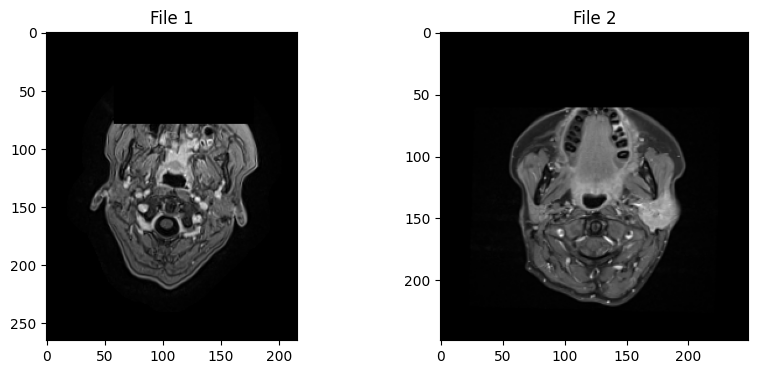

In [104]:
visualize_pair(duplicates[0][0], duplicates[0][1])

In [105]:
def mean_shape(info_dict):
    """Compute mean, std, and median shape from a metadata dictionary."""
    shapes = [v["shape"] for v in info_dict.values() if v and len(v["shape"]) == 3]
    shapes = np.array(shapes)
    mean_shape = np.mean(shapes, axis=0)
    std_shape = np.std(shapes, axis=0)
    median_shape = np.median(shapes, axis=0)
    return mean_shape, std_shape, median_shape


# Compute separately
mean_2023, std_2023, med_2023 = mean_shape(info_2023)
mean_2025, std_2025, med_2025 = mean_shape(info_2025)

# Print results
print("📊 SynthRAD2023 mean shape:", np.round(mean_2023).astype(int))
print("   std:", np.round(std_2023, 1), "median:", med_2023)
print("📊 SynthRAD2025 mean shape:", np.round(mean_2025).astype(int))
print("   std:", np.round(std_2025, 1), "median:", med_2025)

# Combined mean
all_shapes = [v["shape"] for v in info_2023.values() if v] + [
    v["shape"] for v in info_2025.values() if v
]
all_shapes = np.array(all_shapes)
print("\n🧩 Combined mean shape:", np.round(all_shapes.mean(axis=0)).astype(int))

📊 SynthRAD2023 mean shape: [340 275 154]
   std: [125.5  34.   42.6] median: [335.  269.  158.5]
📊 SynthRAD2025 mean shape: [455 410 102]
   std: [104.5  78.2  25.4] median: [475. 427. 102.]

🧩 Combined mean shape: [408 354 124]


# Check normalization/HU Clipping

In [106]:
import torch
import numpy as np

subject = dataset[0]

ct = subject["ct"].data[0].float()
mr = subject["mr"].data[0].float()

print("MRI intensity stats:")
print(
    f"  min={mr.min().item():.2f}, max={mr.max().item():.2f}, mean={mr.mean().item():.2f}"
)

print("CT intensity stats:")
print(
    f"  min={ct.min().item():.2f}, max={ct.max().item():.2f}, mean={ct.mean().item():.2f}"
)


MRI intensity stats:
  min=0.00, max=3075.00, mean=338.86
CT intensity stats:
  min=-1024.00, max=3051.00, mean=-616.21


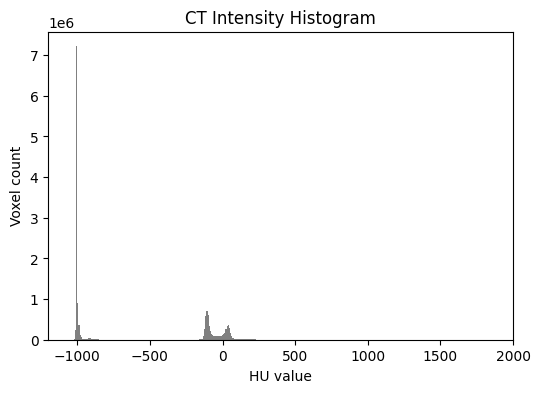

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(ct.flatten().numpy(), bins=500, color="gray")
plt.title("CT Intensity Histogram")
plt.xlabel("HU value")
plt.ylabel("Voxel count")
plt.xlim(-1200, 2000)
plt.show()

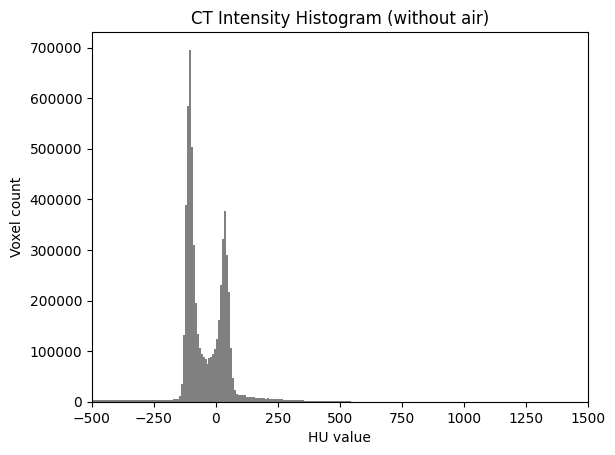

In [108]:
ct_np = ct.numpy()
ct_np = ct_np[ct_np > -900]  # exclude air voxels

plt.hist(ct_np, bins=500, color="gray")
plt.title("CT Intensity Histogram (without air)")
plt.xlabel("HU value")
plt.ylabel("Voxel count")
plt.xlim(-500, 1500)
plt.show()


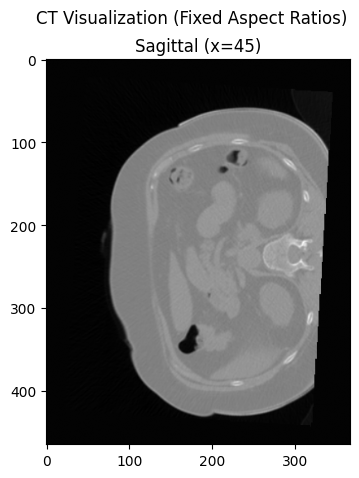

In [109]:
import matplotlib.pyplot as plt
import numpy as np

ct_np = ct.numpy()
sz, sy, sx = subject[
    "ct"
].spacing  # spacing order = (x, y, z)? No → TorchIO gives (x, y, z) in mm
# So reorder to (sz, sy, sx):
sz, sy, sx = sz, sy, sx

z, y, x = [s // 2 for s in ct_np.shape]

plt.figure(figsize=(5, 5))
# Sagittal
plt.imshow(np.flipud(ct_np[:, :, x]), cmap="gray", aspect=sz / sy)
plt.title(f"Sagittal (x={x})")

plt.suptitle("CT Visualization (Fixed Aspect Ratios)")
plt.show()


In [110]:
mins, maxs = [], []
for i in range(0, len(dataset), max(1, len(dataset) // 20)):  # sample ~20 evenly spaced
    ct = dataset[i]["ct"].data[0]
    mins.append(ct.min().item())
    maxs.append(ct.max().item())

print(f"CT range across samples: min={min(mins):.1f}, max={max(maxs):.1f}")

CT range across samples: min=-1024.0, max=3071.0
